# 1. 폴더 정리

* 제공해드린 animals10.zip의 압축을 풀어 그 내용을 살펴보시고, 폴더 구조를 학습에 알맞도록 재구성해주세요
* 특히 각 클래스마다 약 30% 정도의 이미지를 test 폴더에 할당해주세요
* 중간중간 헷갈리다면 이것저것 확인하는 코드를 거쳐보세요 (ex. flat_test[:5]로 앞의 다섯값 확인)
* 궁금한 점이 있을 경우, 슬랙 질문 채널 활용을 적극 권장합니다.

In [ ]:
import os
import glob
import shutil
import random
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Mounted at /content/drive
/content


In [ ]:
### Guideline for convenience ###
# 압축 풀기
!unzip -qq "/content/drive/MyDrive/DSL/animals10.zip"

In [ ]:
# 각 클래스별 파일 개수 확인 -> 변수로 해당 개수 저장
# Tip) 클래스가 10개이므로 각 클래스마다 똑같은 내용의 코드를 계속 써야할까요? 클래스 이름을 리스트로 저장해 for문을 돌리면서 코드를 재사용하는건 어떨까요?
animal_list = os.listdir("./Animals-10")

def class_file(name):
  animal = sorted(glob.glob(f'./Animals-10/{name}/*'))
  return animal, len(animal)

animal_dict = {}
for name in animal_list:
  animal, len_animal = class_file(name)
  animal_dict[f'{name}'] = animal
  animal_dict[f'len_{name}'] = len_animal

In [ ]:
# test에 넣을 이미지 개수 계산
test_count_dict = {}
for name in animal_list:
  test_count_dict[f'{name}_test_count'] = round(animal_dict[f'len_{name}'] * 0.3)

test_count_dict

{'cat_test_count': 500,
 'cow_test_count': 560,
 'chicken_test_count': 929,
 'horse_test_count': 787,
 'elephant_test_count': 434,
 'sheep_test_count': 546,
 'butterfly_test_count': 634,
 'dog_test_count': 1459,
 'spider_test_count': 1446,
 'squirrel_test_count': 559}

In [ ]:
# train, test 폴더 경로 선언 & 만들기
path_dict = {}
for name in animal_list:
  path_dict[f'{name}_train_path'] = './train/%s' % name
  path_dict[f'{name}_test_path'] = './test/%s' % name
  os.makedirs(path_dict[f'{name}_train_path'], exist_ok=True)
  os.makedirs(path_dict[f'{name}_test_path'], exist_ok=True)
path_dict

{'cat_train_path': './train/cat',
 'cat_test_path': './test/cat',
 'cow_train_path': './train/cow',
 'cow_test_path': './test/cow',
 'chicken_train_path': './train/chicken',
 'chicken_test_path': './test/chicken',
 'horse_train_path': './train/horse',
 'horse_test_path': './test/horse',
 'elephant_train_path': './train/elephant',
 'elephant_test_path': './test/elephant',
 'sheep_train_path': './train/sheep',
 'sheep_test_path': './test/sheep',
 'butterfly_train_path': './train/butterfly',
 'butterfly_test_path': './test/butterfly',
 'dog_train_path': './train/dog',
 'dog_test_path': './test/dog',
 'spider_train_path': './train/spider',
 'spider_test_path': './test/spider',
 'squirrel_train_path': './train/squirrel',
 'squirrel_test_path': './test/squirrel'}

In [ ]:
# train, test 폴더로 이미지 split해서 알맞게 집어넣기

def split(name, img_list, test_count, train_path, test_path):
  # img_list : 이미지 경로 리스트
  # test_count : test에 할당할 이미지 개수
  # train_path : train 데이터 넣을 경로
  # test_path : test 데이터 넣을 경로
  
  # 랜덤으로 test_count만큼 이미지 img_list에서 고르기
  # test 담을 이미지 리스트 저장
  test_files=[]
  for i in random.sample(img_list, test_count):
    test_files.append(i)

  train_files = [x for x in img_list if x not in test_files]

  for k in train_files:
    shutil.copy(k, train_path)
  
  for c in test_files:
    shutil.copy(c, test_path)

  print('{} train 폴더 이미지 개수 : {}\n{} test 폴더 이미지 개수 : {}'.format(name,len(glob.glob(train_path+'/*')),name,len(glob.glob(test_path+'/*'))))

for name in animal_list:
  split(name, animal_dict[f'{name}'], test_count_dict[f'{name}_test_count'], path_dict[f'{name}_train_path'], path_dict[f'{name}_test_path'])

cat train 폴더 이미지 개수 : 1168
cat test 폴더 이미지 개수 : 500
cow train 폴더 이미지 개수 : 1306
cow test 폴더 이미지 개수 : 560
chicken train 폴더 이미지 개수 : 2169
chicken test 폴더 이미지 개수 : 929
horse train 폴더 이미지 개수 : 1836
horse test 폴더 이미지 개수 : 787
elephant train 폴더 이미지 개수 : 1012
elephant test 폴더 이미지 개수 : 434
sheep train 폴더 이미지 개수 : 1274
sheep test 폴더 이미지 개수 : 546
butterfly train 폴더 이미지 개수 : 1478
butterfly test 폴더 이미지 개수 : 634
dog train 폴더 이미지 개수 : 3404
dog test 폴더 이미지 개수 : 1459
spider train 폴더 이미지 개수 : 3375
spider test 폴더 이미지 개수 : 1446
squirrel train 폴더 이미지 개수 : 1303
squirrel test 폴더 이미지 개수 : 559


# 2. CNN 모델
수업 코드에 '모델 성능에 대한 고민!!' 부분을 참고해서 **test 이미지 기준 최소 80% 이상**의 모델이 나올 수 있도록 학습을 진행해주세요.
* 중간중간 헷갈리다면 이것저것 확인하는 코드를 거쳐보세요
* 90% 이상의 모델이 이상적이긴 합니다
* 궁금한 점이 있을 경우, 슬랙 질문 채널 활용을 적극 권장합니다.

전반적으로 수업 코드와 비슷하게 짜면 되는데, 생각해봐야 할 것은
* 모든 이미지를 내가 정의하는 하나의 모델에 넣어야함
* 그말은 input 데이터의 차원이 항상 동일해야 된다는 말
* 그런데 과연 내가 가지고 있는 이미지들의 사이즈가 모두 같을까? - 대략 얼마정도 사이즈 가지고 있는지 코드로 확인해보면 더 좋음 (shape 확인)
* 이미지 사이즈를 통일시키기 위해서는 어떻게 해야할까? - transforms의 Resize, RandomCrop 써볼까?
* 동물 이미지에 적합한 Augmentation은 무엇이 있을까?

In [ ]:
# train, test 이미지를 위한 transforms function 정의
# 위에서 말한 포인트들 생각해보기 - 차원에 유의하자!
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
# ImageFolder와 앞서 정의한 transforms function을 활용해 Dataset 객체 (train, test에 대해) 선언
train_data = torchvision.datasets.ImageFolder(
    root = './train',
    transform = transform_train 
)

test_data = torchvision.datasets.ImageFolder(
    root = './test',
    transform = transform_test
)

print(train_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 18325
    Root location: ./train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Dataset ImageFolder
    Number of datapoints: 7854
    Root location: ./test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


In [ ]:
# train, test에 대해 DataLoader 정의
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = 32,      # 일반적으로 batch size = 16, 32
    shuffle=True,         # train dataloader는 epoch마다 데이터 다시 섞어서 batch 만들고 학습! - 학습 효율 up
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size = 32,      # 일반적으로 batch size = 16, 32
    shuffle=False,        # test dataloader는 데이터 매번 섞을 이유가 없음 - 어차피 확인 용도
    num_workers=0
)

In [ ]:
### Model 클래스 정의 - 차원에 유의하자!
# 10개의 클래스를 분류해야 하는 꽤나 복잡한 task - 모델 구조를 어느 정도로 복잡하게 짜볼까?
# 가장 마지막 Linear의 out_features는 얼마로 해야할까?

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        ##### Layer 정의 #####
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1), # (32, 3, 224, 224) -> (32, 16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (32, 16, 224, 224) -> (32, 16, 112, 112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # (32, 32, 112, 112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2), # 0.2 확률로 Dropout
            nn.MaxPool2d(kernel_size=2, stride=2), # (32, 32, 112, 112) -> (32, 32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2), # (32, 32, 56, 56)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (32, 32, 28, 28)
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), # (32, 32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2), # (32, 32, 14, 14)
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), # (32, 32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2) # (32, 32, 7, 7)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(32*7*7,100),
            nn.ReLU(),
            nn.Linear(100,10) # 10은 class, linear 두 개 쓸 수 있다!
        )

        for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
          elif isinstance(m, nn.BatchNorm2d):
              nn.init.constant_(m.weight, 1)
              nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # forward pass 과정
        out = self.layer(x)
        out = out.view(out.size(0),-1)  # FC layer에 들어가기전, flatten! - view 함수 활용
                                        # 가장 첫 차원인 batch_size는 유지하고 나머지 차원들을 하나로 합치기 - [batch_size,16,5,5] -> [batch_size,16*5*5]
        out = self.fc_layer(out)
        return out

In [ ]:
# Device 선언 (GPU 권장)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# 모델 객체 선언
mymodel = MyModel().to(device)
mymodel

MyModel(
  (layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=T

In [ ]:
summary(mymodel, (3,224,224), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 16, 224, 224]             448
       BatchNorm2d-2         [32, 16, 224, 224]              32
              ReLU-3         [32, 16, 224, 224]               0
         MaxPool2d-4         [32, 16, 112, 112]               0
            Conv2d-5         [32, 32, 112, 112]           4,640
       BatchNorm2d-6         [32, 32, 112, 112]              64
              ReLU-7         [32, 32, 112, 112]               0
           Dropout-8         [32, 32, 112, 112]               0
         MaxPool2d-9           [32, 32, 56, 56]               0
           Conv2d-10           [32, 32, 56, 56]          25,632
      BatchNorm2d-11           [32, 32, 56, 56]              64
             ReLU-12           [32, 32, 56, 56]               0
        MaxPool2d-13           [32, 32, 28, 28]               0
           Conv2d-14           [32, 32,

In [ ]:
# loss func, optimizer 정의
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.001, weight_decay=0.0001) 

In [ ]:
# train 함수 정의
def train(epoch):
    print(f'\n[ Train epoch: {epoch+1} ]')

    mymodel.train() # train은 항상 이걸 지정하고 시작! - Dropout, Batch Normalization 등의 효과를 적용하고 진행하기 위함

    running_loss = 0.0
    batch_losses = []
    total = 0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device) # dataloader의 input image와 label도 device에 넣어줘야됨
        
        # DL 학습 기본 코드
        optimizer.zero_grad() # gradient 초기화
        outputs = mymodel(inputs) # 현재 batch의 inputs을 모델에 넣어 outputs 추출 (확률값)
        loss = criterion(outputs, targets) # 추출한 outputs와 원래 label인 targets 사이 loss 계산
        loss.backward() # 계산한 loss 기반으로 gradient 값 계산
        optimizer.step() # weight parameter update

        total += targets.size(0) # batch 데이터 개수 더하기
        running_loss += loss.item()
        batch_losses.append(loss.item())
        
        _, predicted = outputs.max(1) # 확률값 가장 높게 나타난 클래스
        correct += (predicted == targets).sum().item() # 현재 batch 내에서 알맞게 분류한 이미지 개수 더하기
        
        if batch_idx % 300 == 299:
            print(f'\nCurrent batch: {str(batch_idx+1)}')
            print(f'Average train loss of recent 300 batches: {running_loss / 300}') # 이렇게 출력하는 것이 꼭 필요한 것은 아니지만, 중간중간 확인을 위해 매우 권장
            running_loss = 0.0

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_train_loss.append(avg_loss)
    seq_train_acc.append(100*correct/total)
    print('\nTotal train accuarcy:', 100. * correct / total) # 전체 데이터 개수에서 맞게 예측한 비율
    print('Total train loss:', avg_loss)

In [ ]:
# test 함수 정의
def test(epoch):
    print(f'\n[ Test epoch: {epoch+1} ]')

    mymodel.eval() 

    loss = 0
    batch_losses = []
    correct = 0
    total = 0

    with torch.no_grad(): # gradient update 안함 - eval과 torch.no_grad는 하나의 세트
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = mymodel(inputs)
            loss = criterion(outputs, targets)
            batch_losses.append(loss.item())

            total += targets.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_test_loss.append(avg_loss)
    seq_test_acc.append(100 * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', avg_loss)

In [ ]:
# training
seq_train_loss = []
seq_test_loss = []
seq_train_acc = []
seq_test_acc = []

num_epoch = 30

for epoch in range(0, num_epoch):
    train(epoch)
    test(epoch)

torch.save(mymodel.state_dict(), './drive/MyDrive/DSL/mymodel.pt')
print('Model Saved!')


[ Train epoch: 1 ]

Current batch: 300
Average train loss of recent 300 batches: 1.726539538304011

Total train accuarcy: 46.34106412005457
Total train loss: 1.5639575057212802

[ Test epoch: 1 ]

Test accuarcy: 49.82174688057041
Test average loss: 1.4953304386235835

[ Train epoch: 2 ]

Current batch: 300
Average train loss of recent 300 batches: 1.2646598875522614

Total train accuarcy: 58.177353342428376
Total train loss: 1.2247688427021366

[ Test epoch: 2 ]

Test accuarcy: 52.89024700789407
Test average loss: 1.3289824839287656

[ Train epoch: 3 ]

Current batch: 300
Average train loss of recent 300 batches: 1.0990765424569449

Total train accuarcy: 62.14461118690314
Total train loss: 1.100849552616399

[ Test epoch: 3 ]

Test accuarcy: 59.93124522536287
Test average loss: 1.1829045734754422

[ Train epoch: 4 ]

Current batch: 300
Average train loss of recent 300 batches: 1.0359202428658802

Total train accuarcy: 64.63847203274216
Total train loss: 1.0253304790763955

[ Test epoc

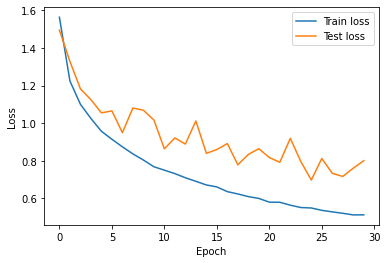

In [ ]:
# loss, accuracy 추이 확인 with plt.plot
plt.plot(range(num_epoch), seq_train_loss, label="Train loss")
plt.plot(range(num_epoch), seq_test_loss, label="Test loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

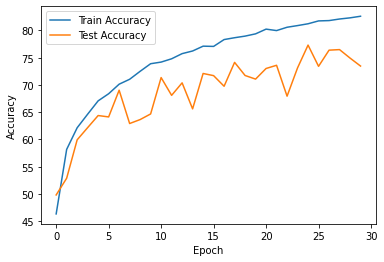

In [ ]:
- ponplt.plot(range(num_epoch), seq_train_acc, label="Train Accuracy")
plt.plot(range(num_epoch), seq_test_acc, label="Test Accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## 결과해석
- Train의 경우 목표했던 Accuracy 80%를 달성하였으며, 일정 수준 감소/증가하는 경향을 보이고 수렴하였으나, Test의 경우 감소/증가 경향을 보이기는 하지만 변동이 크게 나타났다.
- class 간 불균형, Train 데이터의 overfitting 등으로 인해 이러한 문제가 발생한 것으로 보인다.
- optimization을 위해 지금보다 deep하지 않은 모델이 필요할 것 같다.